In [8]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import mapclassify
from pypinyin import lazy_pinyin

In [9]:
# Load Jiangsu county-level shapefile (original CRS: EPSG:4326)
shp_path = "D:/2025manchester/ERP/jiangsu/county.shp"
gdf_county = gpd.read_file(shp_path)

In [10]:
# Reproject immediately after loading
gdf_county = gdf_county.to_crs(epsg=32650)
print("county shp CRS:", gdf_county.crs)

county shp CRS: EPSG:32650


In [11]:
# Load enterprise and university data (columns: x_utm, y_utm)
df_enterprise = pd.read_excel("company_converted-1.xlsx")
df_university = pd.read_excel("university_converted-1.xlsx")

# Convert to GeoDataFrame (directly set CRS to EPSG:32650)
gdf_enterprise = gpd.GeoDataFrame(
    df_enterprise,
    geometry=gpd.points_from_xy(df_enterprise["x_utm"], df_enterprise["y_utm"]),
    crs="EPSG:32650"
)

gdf_university = gpd.GeoDataFrame(
    df_university,
    geometry=gpd.points_from_xy(df_university["x_utm"], df_university["y_utm"]),
    crs="EPSG:32650"
)

In [12]:
# Spatial join: assign points to counties
join_enterprise = gpd.sjoin(gdf_enterprise, gdf_county, how="left", predicate="within")
join_university = gpd.sjoin(gdf_university, gdf_county, how="left", predicate="within")

# Count the number of enterprises and universities per county
enterprise_count = join_enterprise.groupby("区划码").size().reset_index(name="enterprise_count")
university_count = join_university.groupby("区划码").size().reset_index(name="university_count")

# Merge results into county GeoDataFrame
gdf_county = gdf_county.merge(enterprise_count, on="区划码", how="left")
gdf_county = gdf_county.merge(university_count, on="区划码", how="left")

gdf_county[["enterprise_count", "university_count"]] = gdf_county[["enterprise_count", "university_count"]].fillna(0)

D:\anaconda0804\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda0804\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


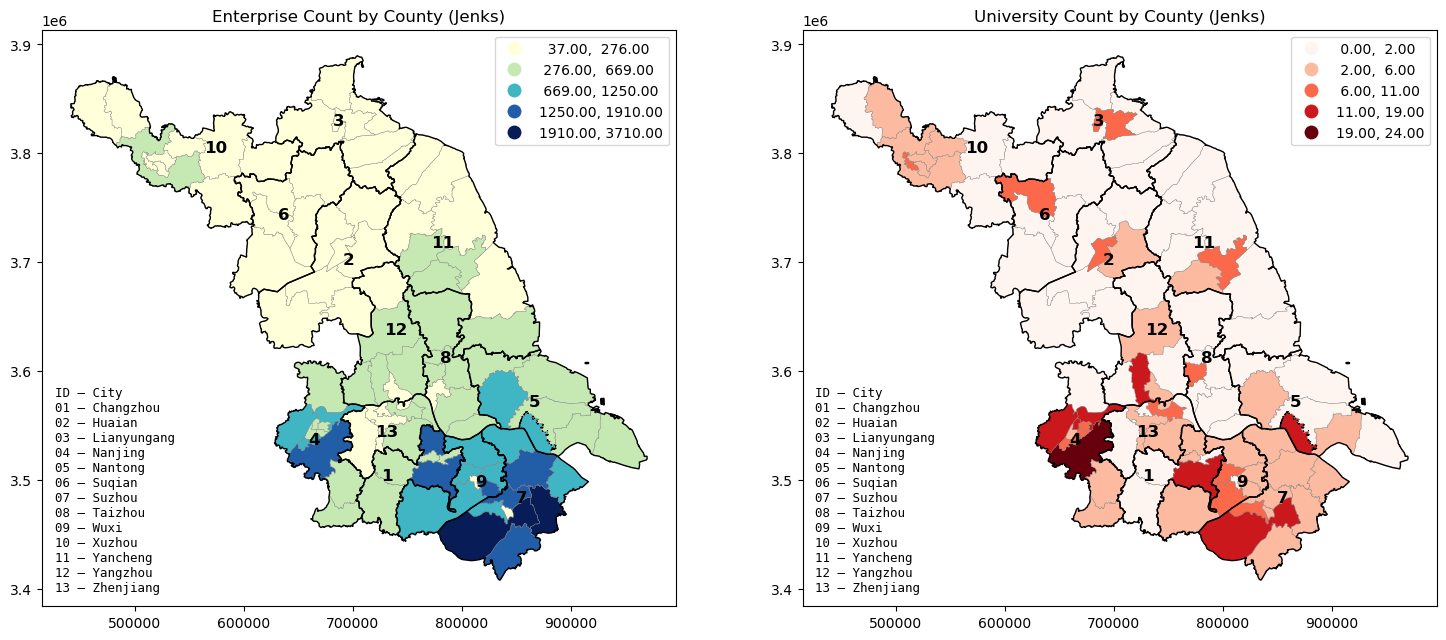

In [13]:
# Dissolve county boundaries into prefecture-level city boundaries
gdf_city = gdf_county.dissolve(by="地级").reset_index()

# Convert Chinese city names into pinyin and remove "shi" suffix if present
def to_pinyin_no_shi(x):
    name = "".join(lazy_pinyin(x)).capitalize()
    if name.endswith("shi"):
        name = name[:-3]
    return name

gdf_city["city_pinyin"] = gdf_city["地级"].apply(to_pinyin_no_shi)

# Sort cities by pinyin and assign new IDs
gdf_city = gdf_city.sort_values("city_pinyin").reset_index(drop=True)
gdf_city["city_id"] = gdf_city.index + 1

# Create legend text for mapping IDs to city names
legend_text = "ID – City\n" + "\n".join(
    f"{row.city_id:02d} – {row.city_pinyin}" for _, row in gdf_city.iterrows()
)

# Create side-by-side plots for enterprises and universities
fig, ax = plt.subplots(1, 2, figsize=(18, 10))

# Plot enterprise counts by county
gdf_county.plot(
    column="enterprise_count",
    cmap="YlGnBu",
    legend=True,
    scheme="NaturalBreaks",
    k=5,
    edgecolor="gray",
    linewidth=0.3,
    categorical=True,
    ax=ax[0]
)
ax[0].set_title("Enterprise Count by County (Jenks)")

# Plot university counts by county
gdf_county.plot(
    column="university_count",
    cmap="Reds",
    legend=True,
    scheme="NaturalBreaks",
    k=5,
    edgecolor="gray",
    linewidth=0.3,
    categorical=True,
    ax=ax[1]
)
ax[1].set_title("University Count by County (Jenks)")

# Overlay prefecture-level city boundaries
gdf_city.boundary.plot(ax=ax[0], color="black", linewidth=1)
gdf_city.boundary.plot(ax=ax[1], color="black", linewidth=1)

# Add city IDs as bold labels at centroid locations
gdf_city["centroid"] = gdf_city.geometry.representative_point()
for idx, row in gdf_city.iterrows():
    x, y = row["centroid"].x, row["centroid"].y
    for a in [ax[0], ax[1]]:
        a.text(x, y, str(row["city_id"]),
               fontsize=12, fontweight="bold",
               ha="center", color="black")

# Add ID-to-city mapping as text in the bottom-left of both plots
for a in [ax[0], ax[1]]:
    a.text(
        0.02, 0.02, legend_text,
        transform=a.transAxes,
        fontsize=9, family="monospace",
        va="bottom", ha="left",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
    )

plt.show()